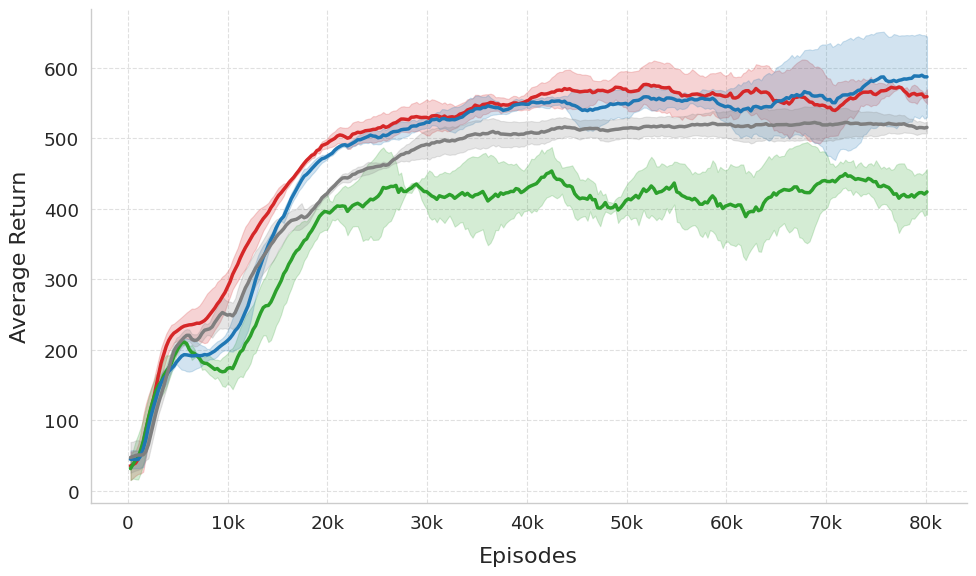

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------------------------
# 1. 가상의 데이터 생성 (이름을 요청하신 4가지로 변경했습니다)
# -----------------------------------------------------------
def create_dummy_data():
    # 요청하신 순서대로 리스트 생성
    methods = ["MATE", "GPT-2", "LSTM", "Markov"]
    seeds = [1, 2, 3]
    steps = np.arange(0, 100000, 1000) 
    
    os.makedirs('rl_results', exist_ok=True)
    
    for i, method in enumerate(methods):
        for seed in seeds:
            # MATE가 가장 성능이 좋게 나오도록 가상 데이터 설정 (예시)
            perf_factor = 15 - (i * 2) 
            base_performance = np.log(steps + 100) * perf_factor
            noise = np.random.normal(0, 5, size=len(steps))
            returns = base_performance + noise
            
            df = pd.DataFrame({'Step': steps, 'Return': returns})
            filename = f"rl_results/{method}_seed{seed}.csv"
            df.to_csv(filename, index=False)

# 테스트를 위해 주석 해제하여 데이터 생성 (본인의 데이터가 있다면 주석 처리)
# create_dummy_data()
# print("가상 데이터 생성 완료.")

# -----------------------------------------------------------
# 2. 데이터 로드 및 전처리
# -----------------------------------------------------------
def smooth(scalars, weight=0.9):
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

def load_data(data_dir):
    all_data = []
    method_name_to_Method = {"mate": "MATE", "gpt": "GPT-2", "lstm": "LSTM", "markov": "Markov"}
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            filepath = os.path.join(data_dir, filename)
            df = pd.read_csv(filepath)
            
            # 파일명 파싱 (규칙: MethodName_seedX.csv)
            parts = filename.replace('.csv', '').split('_seed')
            method_name = parts[0]
            seed = parts[1]
            
            df['Return_smooth'] = smooth(df['Return'].values, weight=0.9)
            df['Method'] = method_name_to_Method.get(method_name, method_name)
            df['Seed'] = seed
            all_data.append(df)
            
    return pd.concat(all_data, ignore_index=True)

# -----------------------------------------------------------
# 3. 논문용 Plotting (수정된 부분)
# -----------------------------------------------------------
def plot_results(df):
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)
    plt.figure(figsize=(10, 6))

    # 1. 원하는 순서 지정
    target_order = ["MATE", "GPT-2", "LSTM", "Markov"]
    
    # 2. 원하는 색상 지정 (논문에 어울리는 세련된 헥사 코드 사용)
    # Red: #d62728 (Muted Red)
    # Green: #2ca02c (Muted Green)
    # Blue: #1f77b4 (Muted Blue)
    # Grey: #7f7f7f (Muted Grey)
    custom_palette = {
        "MATE": "#d62728",   # Red
        "GPT-2": "#2ca02c",  # Green
        "LSTM": "#1f77b4",   # Blue
        "Markov": "#7f7f7f"  # Grey
    }

    ax = sns.lineplot(
        data=df,
        x='Step',
        y='Return_smooth',
        hue='Method',
        hue_order=target_order,    # <--- 순서 강제 적용
        palette=custom_palette,    # <--- 색상 강제 적용
        # style='Method',            # (선택) 라인 스타일도 다르게 하여 흑백 인쇄 대응
        errorbar='sd',
        linewidth=2.5,
        legend=False
    )
    
    ax.set_xlabel("Episodes", fontsize=16, labelpad=10)
    ax.set_ylabel("Average Return", fontsize=16, labelpad=10)
    
    # X축 포맷 (1k 단위)
    from matplotlib.ticker import FuncFormatter
    def format_func(value, tick_number):
        return f'{int(value/1000)}k' if value >= 1000 else int(value)
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    
    
    sns.despine()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('rl_benchmark_graph.png', dpi=300)
    plt.show()

# 실행
data_dir = 'rl_results'
df = load_data(data_dir)
plot_results(df)

legend_horizontal.png (Title: Model) 저장 완료.


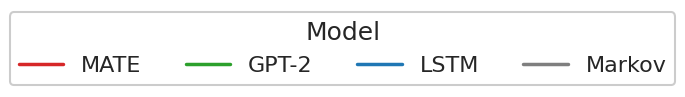

legend_vertical.png (Title: Model) 저장 완료.


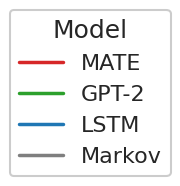

In [34]:
def save_standalone_legend(orientation='horizontal', title="Model"):
    """
    orientation: 'horizontal' or 'vertical'
    title: 범례의 제목 (예: "Model", "Architecture")
    """
    fig, ax = plt.subplots(figsize=(1, 1))
    
    # 가짜 핸들 생성 (이전과 동일)
    handles = []
    for label in target_order:
        color = custom_palette[label]
        # Line2D 생성
        line = mlines.Line2D([], [], color=color, linewidth=2.5, label=label)
        handles.append(line)
        
    if orientation == 'horizontal':
        ncol = len(target_order)
    else:
        ncol = 1

    # [수정] title과 title_fontsize 추가
    legend = ax.legend(
        handles=handles,
        loc='center',
        ncol=ncol,
        fontsize=16,
        
        # --- 제목 설정 부분 ---
        title=title,          # <--- 제목 내용 (예: "Model")
        title_fontsize=18,    # <--- 제목 폰트 크기 (내용보다 약간 크게 추천)
        # -------------------
        
        frameon=True,
        framealpha=0.2,
        edgecolor='black'
    )
    
    # (선택 사항) 제목 정렬: 기본은 'center'이나 'left'로 두고 싶다면 아래 주석 해제
    # legend._legend_box.align = "left"

    # Get the frame of the legend and set its line width
    frame = legend.get_frame()
    frame.set_linewidth(1.5) # Set the desired thickness (e.g., 3.0)

    ax.axis('off')
    
    filename = f"legend_{orientation}.png"
    fig.savefig(
        filename, 
        dpi=300, 
        bbox_inches='tight', 
        bbox_extra_artists=[legend]
    )
    print(f"{filename} (Title: {title}) 저장 완료.")
    plt.show()

# --- 사용 예시 ---
# 제목을 "Architecture"로 설정하여 가로 범례 생성
save_standalone_legend(orientation='horizontal', title="Model")
save_standalone_legend(orientation='vertical', title="Model")